In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): 
        return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [13]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [14]:
def get_tuples(files):
    return [[f, Path(str(f).replace('datasetClean','datasetAltura2'))] for f in get_image_files(files)]

In [15]:
class MyTransform(Transform):
    def __init__(self): self.aug = aug_transforms(size=224,flip_vert=True,max_zoom=1.0)
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [16]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [17]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [18]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=64)

In [19]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50VolumeHeightOrtofoto')
]

In [20]:
from fastai.metrics import mae,rmse,mse

In [21]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1,x2=x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [22]:
encoder = create_body(resnet50, cut=-2)

In [23]:
head = create_head(4096, 1, ps=0.5)
model = SiameseModel(encoder, head)

In [24]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [25]:
learn = Learner(dls, model,splitter=siamese_splitter,
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [26]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,19.857357,21.042393,3.616969,4.587199,21.042393,00:04


Better model found at epoch 0 with valid_loss value: 21.04239273071289.


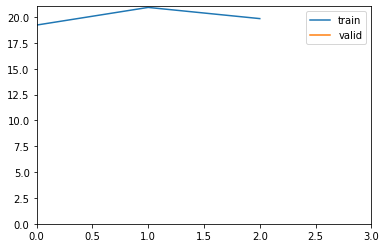

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,19.757782,21.055151,3.631546,4.588589,21.055151,00:04
1,20.113754,21.176540,3.645785,4.601797,21.176540,00:03
2,23.747698,166.633667,11.114734,12.908667,166.633667,00:03
3,23.247715,33.451778,5.457046,5.783751,33.451778,00:04
4,21.159525,23.053446,4.210384,4.801400,23.053446,00:03
5,20.255672,19.561621,3.688131,4.422852,19.561621,00:03
6,19.421690,18.088326,3.654172,4.253037,18.088326,00:03
7,18.509106,17.307762,3.735907,4.160260,17.307762,00:04
8,17.730503,17.572952,3.902001,4.192011,17.572952,00:04
9,16.964224,17.714643,3.993982,4.208877,17.714643,00:04


Better model found at epoch 0 with valid_loss value: 21.055150985717773.


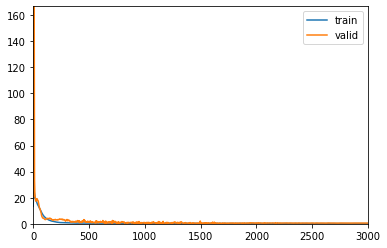

Better model found at epoch 5 with valid_loss value: 19.561620712280273.
Better model found at epoch 6 with valid_loss value: 18.08832550048828.
Better model found at epoch 7 with valid_loss value: 17.307762145996094.
Better model found at epoch 15 with valid_loss value: 15.842646598815918.
Better model found at epoch 16 with valid_loss value: 14.520483016967773.
Better model found at epoch 17 with valid_loss value: 12.896576881408691.
Better model found at epoch 18 with valid_loss value: 11.895334243774414.
Better model found at epoch 19 with valid_loss value: 11.77527904510498.
Better model found at epoch 20 with valid_loss value: 10.873631477355957.
Better model found at epoch 21 with valid_loss value: 9.943751335144043.
Better model found at epoch 22 with valid_loss value: 8.870100021362305.
Better model found at epoch 23 with valid_loss value: 7.963913440704346.
Better model found at epoch 24 with valid_loss value: 6.404447078704834.
Better model found at epoch 25 with valid_loss 

In [27]:
learn.fine_tune(1000,base_lr=3e-2)

In [28]:
# learn.load('resnetrs50Masav2HeightOrtofotov2')

In [29]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [30]:
def is_test(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [31]:
dbtest = DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = [Resize(224)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [32]:
dlstest = dbtest.dataloaders(path,bs=16)

In [33]:
learn.dls=dlstest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.553280770778656.


(#4) [0.625156044960022,0.553280770778656,0.7906680703163147,0.625156044960022]

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
preds,gt = learn.tta()

In [37]:
mean_absolute_error(gt,preds)

0.5618664